# Data Acquisition and Processing

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Get and process input data

var = dict([ (1, ('WHITE',1)),(2, ('ALCHY',1)),(3, ('JUNKY',1)),(4, ('SUPER',1)),
                (5, ('MARRIED',1)),(6, ('FELON',1)),(7, ('WORKREL',1)),(8, ('PROPTY',1)),
                (9, ('PERSON',1)),(10, ('MALE',1)),(11, ('PRIORS',2)),(13, ('SCHOOL',2)),
                (15, ('RULE',2)),(17, ('AGE',3)),(20, ('TSERVD',3)),
                (23, ('FOLLOW',2)),(25, ('RECID',1)),(26, ('TIME',2)),(28, ('FILE',1)) ] )

def cleanData(data):
    res = []
    cols = [x[1][0] for x in var.items()] # Get the column names
    for line in data:
        line = line.strip()
        
        curLine = []
        for i in xrange(len(line)):
            if i+1 not in var:
                continue
            name, sz = var[i+1]            
            curLine.append(int(line[i:i+sz]))
        
        res.append(curLine)
    
    ret = pd.DataFrame(data=res, columns=cols)
    ret = ret[ret.FILE != 3] # Remove incomplete data points
    
    # Remove some irrelevant columns
    del ret['TIME']
    del ret['FILE']
    del ret['FOLLOW']
    return ret
    

raw_1978 = open('data/1978.txt','rb').readlines()
raw_1980 = open('data/1980.txt','rb').readlines()

d1978 = cleanData(raw_1978)
d1980 = cleanData(raw_1980)

# Baseline Classifier

In [4]:
from __future__ import division

score_baseline_1 = np.size(d1978[d1978.RECID == 1].RECID.values) / np.size(d1978.RECID.values)
score_baseline_0 = np.size(d1978[d1978.RECID == 0].RECID.values) / np.size(d1978.RECID.values)
print "baseline classifier everyone to 0: ", int(score_baseline_0*100) , "%"
print "baseline classifier everyone to 1: ", int(score_baseline_1*100) , "%"

baseline classifier everyone to 0:  62 %
baseline classifier everyone to 1:  37 %


# Random forest

#### Fit model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

d78train, d78test = train_test_split(d1978, test_size = 0.3)
X78train = d78train.drop('RECID', axis=1).values
y78train = d78train.RECID.values
X78test = d78test.drop('RECID', axis=1).values
y78test = d78test.RECID.values

In [6]:
def score_random_forest(Xtrain, ytrain, Xtest, ytest, n_estimators=10, criterion='gini', max_features='auto'):
    clf= RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_features= max_features)
    clf.fit(Xtrain, ytrain)
    score_train = clf.score(Xtrain, ytrain)
    score_test = clf.score(Xtest, ytest)
    return score_train, score_test, clf.feature_importances_

In [7]:
a, b, clf = score_random_forest(X78train, y78train, X78test, y78test)
print "Train score with default parameters:", a
print "Test score with default parameters:", b

Train score with default parameters: 0.979888613861
Test score with default parameters: 0.655844155844


In [8]:
criterions = ['gini', 'entropy']
nb_trees = np.arange(25,100,5)
nb_features = np.arange(1,11)

In [9]:
def best_parameters(Xtrain, ytrain, Xtest, ytest, criterions, nb_trees, nb_features):

    score_tab = pd.DataFrame(columns=['loss', 'nb_trees', 'nb_features', 'test_score', 'train_score', 'features_importance'])
    counter = 0 

    for loss in criterions:
        for n_estimators in nb_trees:
            for max_features in nb_features:
                
                score_train, score_test, features_weights = \
                score_random_forest(Xtrain, ytrain, Xtest, ytest, n_estimators=n_estimators, criterion=loss, max_features=max_features) 
                score_tab.loc[counter] = [loss, n_estimators, max_features, score_test, score_train, features_weights]
                counter += 1

    return score_tab

In [45]:
%%time
scores =  best_parameters(X78train, y78train, X78test, y78test, criterions, [10000] , [5])
print scores.head(5)

      loss  nb_trees  nb_features  test_score  train_score  \
0     gini     10000            5    0.674603     0.999381   
1  entropy     10000            5    0.674603     0.999381   

                                 features_importance  
0  [0.0309075385846, 0.0244703165007, 0.030358633...  
1  [0.0305797865142, 0.0243134765459, 0.030900133...  
Wall time: 5min 1s


In [10]:
%%time
scores =  best_parameters(X78train, y78train, X78test, y78test, criterions, nb_trees , nb_features)
print scores.head(5)

   loss  nb_trees  nb_features  test_score  train_score  \
0  gini        25            1    0.660173     0.996906   
1  gini        25            2    0.669553     0.997215   
2  gini        25            3    0.669553     0.997215   
3  gini        25            4    0.663781     0.997215   
4  gini        25            5    0.672439     0.998144   

                                 features_importance  
0  [0.0240879773299, 0.0202378041461, 0.018445413...  
1  [0.0301845371794, 0.0216299763803, 0.024179428...  
2  [0.0269262975884, 0.0224086691992, 0.029768352...  
3  [0.0313793331865, 0.0274410363012, 0.029382370...  
4  [0.0340285095375, 0.0254192853085, 0.030366553...  
Wall time: 4min 53s


#### Save Data

In [11]:
# save file to /data/ folder
file_path = "./data/random_forest_scores.csv"
scores.to_json(path_or_buf= file_path)

In [12]:
# recover scores from /data/ folder
#file_path = "./data/random_forest_scores.csv"
#scores = pd.read_json(file_path)
#scores.head(5)

#### Analysis

In [13]:
def relevant_features(scores, threshold = 0.98):
    max_score = np.max(scores.test_score.values)
    print "max score on test set is: ", int(max_score*100), "%"
    
    #extract entries that pass a certain threshold
    winner = scores[scores.test_score > max_score * threshold]
    
    # features used in the selection process
    features_list = pd.DataFrame(columns=['WHITE', 'ALCHY', 'JUNKY', 'SUPER', 'MARRIED', 'FELON',
       'WORKREL', 'PROPTY', 'PERSON', 'MALE', 'PRIORS', 'SCHOOL',
       'RULE', 'AGE', 'TSERVD'])
    
    # create a dataframe with the importance coefficients for each feature
    for i in xrange(len(winner.features_importance.values)):
        features_list.loc[i] = winner.features_importance.values[i]
    
    return features_list, winner.drop('features_importance', axis=1)

In [20]:
features_weights, top_scorers = relevant_features(scores, threshold = 0.985)
print "we are including in top scores ", int(len(top_scorers) / len(scores) * 100) , "% of the sample"
print top_scorers.head(5)

max score on test set is:  68 %
we are including in top scores  10 % of the sample
    loss  nb_trees  nb_features  test_score  train_score
23  gini        35            4    0.678932     0.998453
25  gini        35            6    0.684704     0.998762
32  gini        40            3    0.680375     0.998762
34  gini        40            5    0.683261     0.999072
36  gini        40            7    0.683261     0.998762


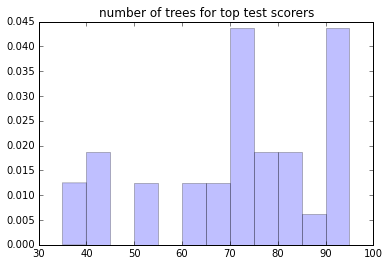

In [42]:
plt.title("number of trees for top test scorers")
plt.hist(top_scorers.nb_trees.values, bins=12, normed=True, color='b', alpha = 0.25)
plt.show()

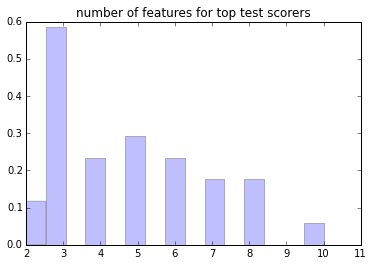

In [22]:
plt.title("number of features for top test scorers")
plt.hist(top_scorers.nb_features.values, bins=15, normed=True, color='b', alpha = 0.25)
plt.show()

In [17]:
print features_weights.head(10)

      WHITE     ALCHY     JUNKY     SUPER   MARRIED     FELON   WORKREL  \
0  0.027672  0.026039  0.030817  0.032681  0.025796  0.020389  0.031944   
1  0.028776  0.025371  0.030955  0.032682  0.024949  0.020042  0.033548   
2  0.034686  0.024705  0.030558  0.031941  0.025562  0.017471  0.030774   
3  0.030396  0.023653  0.031681  0.032606  0.025916  0.019934  0.030916   
4  0.032009  0.023567  0.029426  0.032413  0.026078  0.018147  0.031467   
5  0.031879  0.025100  0.031197  0.032985  0.027000  0.018114  0.030303   
6  0.028530  0.023039  0.028779  0.032112  0.025528  0.018485  0.031342   
7  0.030530  0.024049  0.031362  0.032156  0.024907  0.019128  0.032126   
8  0.029848  0.023189  0.028724  0.030323  0.023115  0.018587  0.029973   
9  0.032315  0.024817  0.031617  0.032463  0.025431  0.020167  0.031411   

     PROPTY    PERSON      MALE    PRIORS    SCHOOL      RULE       AGE  \
0  0.020870  0.010313  0.012501  0.076603  0.123440  0.071259  0.266270   
1  0.019497  0.009766  0

## We adjust the features

In [18]:
X78train_adjusted = d78train.drop(['PERSON', 'RECID', 'FELON', 'PROPTY', 'MALE'], axis=1).values
X78test_adjusted = d78test.drop(['PERSON', 'RECID', 'FELON', 'PROPTY', 'MALE'], axis=1).values
nb_trees_adjusted = np.arange(65,90,2)
nb_features_adjusted = np.arange(4,7)

In [19]:
%%time
scores_adjusted =  best_parameters(X78train_adjusted, y78train, X78test_adjusted, y78test, criterions, nb_trees_adjusted , nb_features_adjusted)

Wall time: 58.9 s


In [23]:
def relevant_features_adjusted(scores_tab, threshold = 0.98):
    max_score = np.max(scores_tab.test_score.values)
    print "max score on test set is: ", max_score
    
    #extract entries that pass a certain threshold
    winner = scores_tab[scores_tab.test_score > max_score * threshold]
    
    # features used in the selection process
    features_list = pd.DataFrame(columns=['WHITE', 'ALCHY', 'MARRIED', 'JUNKY', 'SUPER', 'WORKREL', 'PRIORS', 'SCHOOL',
       'RULE', 'AGE', 'TSERVD'])
    
    # create a dataframe with the importance coefficients for each feature
    for i in xrange(len(winner.features_importance.values)):
        features_list.loc[i] = winner.features_importance.values[i]
    
    return features_list, winner.drop('features_importance', axis=1)

In [24]:
features_weights_adjusted, top_scorers_adjusted = relevant_features_adjusted(scores_adjusted, threshold = 0.99)
print "we are including in top scores ", int(len(top_scorers_adjusted) / len(scores_adjusted) * 100) , "% of the sample"
print top_scorers_adjusted.head(5)

max score on test set is:  0.67316017316
we are including in top scores  15 % of the sample
       loss  nb_trees  nb_features  test_score  train_score
6      gini        69            4    0.667388     0.999381
8      gini        69            6    0.666667     0.999381
12     gini        73            4    0.670996     0.999381
13     gini        73            5    0.666667     0.999381
52  entropy        73            5    0.668831     0.999381


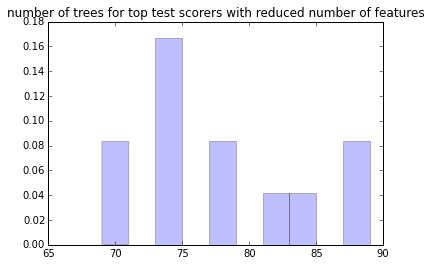

In [25]:
plt.title("number of trees for top test scorers with reduced number of features")
plt.hist(top_scorers_adjusted.nb_trees.values, bins=10, normed=True, color='b', alpha = 0.25)
plt.show()

In [22]:
print features_weights_adjusted.head(10)

      WHITE     ALCHY   MARRIED     JUNKY     SUPER   WORKREL    PRIORS  \
0  0.031557  0.025421  0.032979  0.036523  0.025268  0.034421  0.087508   
1  0.030122  0.024756  0.031666  0.036160  0.026289  0.034675  0.081925   
2  0.032151  0.026203  0.031973  0.035802  0.025476  0.033800  0.080804   
3  0.032388  0.025840  0.031920  0.036071  0.025078  0.033650  0.081021   
4  0.029979  0.027587  0.031611  0.033370  0.025676  0.034664  0.088119   
5  0.031541  0.025909  0.031469  0.036206  0.026172  0.034432  0.085270   
6  0.031773  0.025244  0.029330  0.033498  0.024007  0.032964  0.082314   
7  0.031007  0.025224  0.031031  0.035957  0.025351  0.035731  0.086739   
8  0.032369  0.025705  0.032240  0.035576  0.026392  0.034099  0.080940   
9  0.029495  0.025496  0.031784  0.035169  0.027047  0.033461  0.088346   

     SCHOOL      RULE       AGE    TSERVD  
0  0.124062  0.075538  0.288032  0.238690  
1  0.123118  0.071212  0.295701  0.244376  
2  0.123912  0.070063  0.298227  0.241588 

# 1980 Data set

In [27]:
d80train, d80test = train_test_split(d1980, test_size = 0.3)
X80train = d80train.drop('RECID', axis=1).values
y80train = d80train.RECID.values
X80test = d80test.drop('RECID', axis=1).values
y80test = d80test.RECID.values

In [26]:
score_baseline_1 = np.size(d1980[d1980.RECID == 1].RECID.values) / np.size(d1980.RECID.values)
score_baseline_0 = np.size(d1980[d1980.RECID == 0].RECID.values) / np.size(d1980.RECID.values)
print "baseline classifier everyone to 0: ", int(score_baseline_0*100) , "%"
print "baseline classifier everyone to 1: ", int(score_baseline_1*100) , "%"

baseline classifier everyone to 0:  62 %
baseline classifier everyone to 1:  37 %


In [28]:
criterions = ['gini', 'entropy']
nb_trees = np.arange(25,100,5)
nb_features = np.arange(1,11)

In [31]:
%%time
scores80 =  best_parameters(X80train, y80train, X80test, y80test, criterions, nb_trees , nb_features)
print scores.head(5)

   loss  nb_trees  nb_features  test_score  train_score  \
0  gini        25            1    0.660173     0.996906   
1  gini        25            2    0.669553     0.997215   
2  gini        25            3    0.669553     0.997215   
3  gini        25            4    0.663781     0.997215   
4  gini        25            5    0.672439     0.998144   

                                 features_importance  
0  [0.0240879773299, 0.0202378041461, 0.018445413...  
1  [0.0301845371794, 0.0216299763803, 0.024179428...  
2  [0.0269262975884, 0.0224086691992, 0.029768352...  
3  [0.0313793331865, 0.0274410363012, 0.029382370...  
4  [0.0340285095375, 0.0254192853085, 0.030366553...  
Wall time: 4min 8s


In [32]:
# save file to /data/ folder
file_path = "./data/random_forest_scores.csv"
scores80.to_json(path_or_buf= file_path)

In [37]:
features_weights80, top_scorers80 = relevant_features(scores80, threshold = 0.985)
print "we are including in top scores ", float(len(top_scorers80)) / len(scores) * 100 , "% of the sample"
print top_scorers.head(5)

max score on test set is:  66 %
we are including in top scores  16.3333333333 % of the sample
    loss  nb_trees  nb_features  test_score  train_score
23  gini        35            4    0.678932     0.998453
25  gini        35            6    0.684704     0.998762
32  gini        40            3    0.680375     0.998762
34  gini        40            5    0.683261     0.999072
36  gini        40            7    0.683261     0.998762


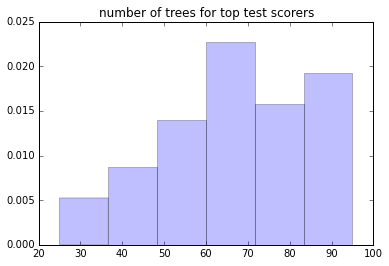

In [34]:
plt.title("number of trees for top test scorers")
plt.hist(top_scorers80.nb_trees.values, bins=6, normed=True, color='b', alpha = 0.25)
plt.show()

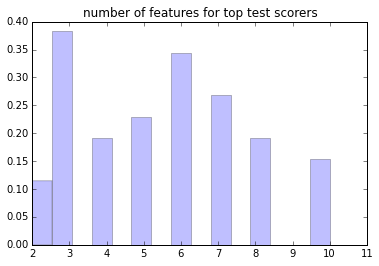

In [35]:
plt.title("number of features for top test scorers")
plt.hist(top_scorers80.nb_features.values, bins=15, normed=True, color='b', alpha = 0.25)
plt.show()